## Self-TICA: Learning slow modes via self-supervised learning.

## Introduction
### Learning evoluation operators by self-supervised learning

The transfer (Koopman) operator $\mathcal{E}$ governs the time evolution of a system's probability density, driving it toward the equilibrium Boltzmann distribution. Formally, $\mathcal{E}$ advances an observable $f$ forward in time by mapping it to its time-lagged conditional expectation. Given the system state $\mathbf{x}_t$ at time $t$, this can be formally expressed as:

$$
(\mathcal{E}f)(\mathbf{x}_t)
= \mathbb{E}[\,f(\mathbf{x}_{t+\tau}) \mid \mathbf{x}_t\,]
= \mathbb{E}_{\mathbf{x}_{t+\tau}\sim p}\big[r(\mathbf{x}_t, \mathbf{x}_{t+\tau})\, f(\mathbf{x}_{t+\tau})\big]
$$
where $r(\mathbf{x}_t, \mathbf{x}_{t+\tau})$ denotes the density ratio between the joint and product distributions of configurations at time $t$ and $t+\tau$.

To approximate this ratio, we introduce a learned feature space in which the temporal correlations are captured through a bilinear form:
$$
r(\mathbf{x}_t,\mathbf{x}_{t+\tau}) \;\approx\; \langle z_t,\, P z_{t+\tau}\rangle
$$
where an encoder $\varphi$ maps configurations to latent vectors $z_t=\varphi(\mathbf{x}_t)$, and a linear operator $P$ models the dynamical coupling between latent variables across the lag time $\tau$.

The parameters $(\varphi,P)$ are learned by minimizing the expected squared discrepancy between the true and modeled density ratios under the product measure $p(\mathbf{x}_t)\,p(\mathbf{x}_{t+\tau})$:
$$
\varepsilon(\varphi, P) =
\mathbb{E}_{\mathbf{x}_t, \mathbf{x}_{t+\tau}}\!\left[
\big(r(\mathbf{x}_t,\mathbf{x}_{t+\tau}) - \langle z_t,\, P z_{t+\tau}\rangle\big)^2
\right]
$$
Through this self-supervised objective, the encoder learn a representation that captures the system's slow modes, effectively disentangling the dominant of dynamical processes without requiring labeled data.

### Connection with VAMP-2 score
For any fixed $\varphi$, when the predictor P reaches its optimal form $P^* = C_0^{-1} C_\tau$, where $\mathbf{C}_0 = \mathbb{E}\!\left[\varphi(\mathbf{x}_{t}) \varphi(\mathbf{x}_{t})^\top\right]$ and $ \mathbf{C}_\tau = \left\langle \varphi(\mathbf{x}_{t}) \varphi(\mathbf{x}_{t+\tau})^\top \right\rangle$, the self-supervised loss $\varepsilon(\phi,P^*)$ converges to the negative VAMP-2 score:
$$
\varepsilon(\phi, P^*) = -\operatorname{Tr}\left( C_0^{-1} C_\tau C_\tau^\top \right) = -\text{VAMP}_2(\varphi)
$$
This revealing that minimizing the self-supervised loss is equivalent to maximizing the VAMP-2 score, a well-established metric for learning slow modes in time-series data.

### Extract CVs from TICA
After training the encoder $\varphi$ (either a feed-forward neural network or a graph neural network), we can apply **Time-Lagged Independent Component Analysis (TICA)** to the learned evolution operators to extract the CVs. TICA identifies the dominant slow modes by maximizing the time-lagged autocorrelation of the encoded features, yielding CVs that best characterize the system’s slow conformational transitions. This procedure is conceptually analogous to Deep-TICA, where neural representations are refined to capture long-timescale dynamics in a non-linear latent space.

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

## Load data

In [2]:
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule

filenames = [ "data/muller-brown/unbiased/high-temp/COLVAR" ]

# load file
df = load_dataframe(filenames)

# get descriptors
X = df.filter(regex='p.x|p.y').values

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X, lag_time=1)

# create datamodule 
datamodule = DictModule(dataset, lengths=[0.8, 0.2])

/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/mlcolvar/utils/timelagged.py:140: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn(
/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/mlcolvar/utils/timelagged.py:186: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_t = torch.stack(x_t) if type(x) == torch.Tensor else torch.Tensor(x_t)


### Define model
Here are a few tips and tricks about the hyperparameters:
- The self-supervised loss $\varepsilon(\phi, P^*)$ converges to the negative VAMP-2 score only when the predictor $P$ reaches its optimal form $P^*$. Therefore, do not be confused if the eigenvalues decrease during the initial stages of training, this is a normal behavior.
- The algorithm requires sufficient model expressiveness so that the predictor $P$ can approximate its optimal form.  If the predictor is too weak, the eigenvalues may collapse toward zero. It is recommended to use an encoder with at least three layers to ensure stable learning.
- Beware of overfitting. It is recommended to stop training once the eigenvalues have stabilized or converged, as continuing beyond this point may cause the learned CVs to become overly sharp or narrowly shaped.

In [3]:
from mlcolvar.cvs import SelfTICA

n_components = 1
encoder_layers = [2, 15, 15, 5]
options= {'encoder': {'activation': 'shifted_softplus'}}

model = SelfTICA(encoder_layers=encoder_layers, n_cvs=n_components, options=options)

model

SelfTICA(
  (loss_fn): RegSpectralLoss()
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=15, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=15, out_features=5, bias=True)
    )
  )
  (linear): Linear(in_features=5, out_features=5, bias=False)
  (tica): TICA(in_features=5, out_features=1)
)

### Define Trainer & Fit

In [4]:
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()

# define trainer
trainer = lightning.Trainer(callbacks=[metrics],
                     max_epochs=400, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3 ...
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To proper

/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s, v_num=1]


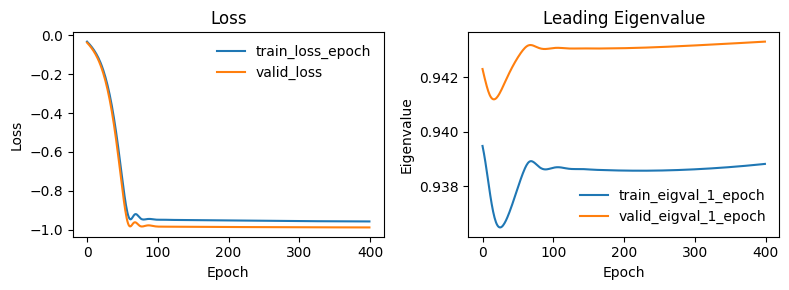

In [18]:
from mlcolvar.utils.plot import plot_metrics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

plot_metrics(
    metrics.metrics,
    keys=['train_loss_epoch', 'valid_loss'],
    ax=ax1,
    yscale='linear'
)
ax1.set_ylabel('Loss')
ax1.set_title('Loss')

plot_metrics(
    metrics.metrics,
    keys=['train_eigval_1_epoch', 'valid_eigval_1_epoch'],
    ax=ax2,
    yscale='linear'
)
ax2.set_ylabel('Eigenvalue')
ax2.set_title('Leading Eigenvalue')

plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

### Plot FES

Text(0, 0.5, 'FES (kJ/mol)')

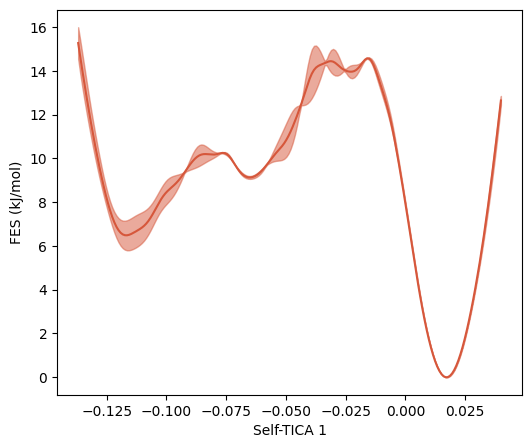

In [7]:
from mlcolvar.utils.fes import compute_fes

fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)

# compute cvs
with torch.no_grad():
    model.eval()
    s = model(torch.Tensor(X)).numpy()

fes,grid,bounds,error = compute_fes(s,
                                    temp=300,
                                    blocks=2,
                                    bandwidth=0.02, scale_by='range',
                                    plot=True, plot_max_fes=100, ax = ax)

ax.set_xlabel('Self-TICA 1')
ax.set_ylabel('FES (kJ/mol)')

### Plot CVs isolines

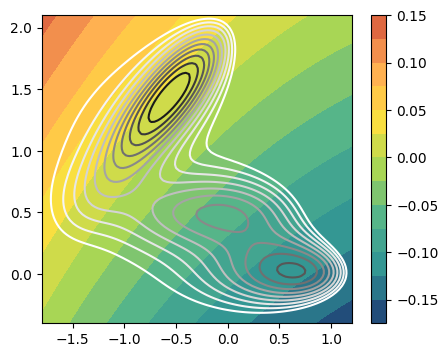

In [8]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]

    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, ax=ax)
    #ax.scatter(X[:,0],X[:,1],s=1, alpha=0.2,c='w')

### Predict other lag-time

In [9]:
dataset = create_timelagged_dataset(X, lag_time=10,progress_bar=True)
datamodule = DictModule(dataset,lengths=[1], batch_size=5000, random_split=False, shuffle=False)
datamodule.setup()
model.compute_tica(datamodule, lag_time=10, update_optimal=True)

100%|██████████| 4989/4989 [00:01<00:00, 3350.41it/s]
/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/mlcolvar/data/datamodule.py:133: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


(array([0.7558018]),
 array([[ 0.07160396],
        [-0.69823588],
        [ 0.6653514 ],
        [ 0.2379461 ],
        [-0.08960298]]))

Text(0, 0.5, 'FES (kJ/mol)')

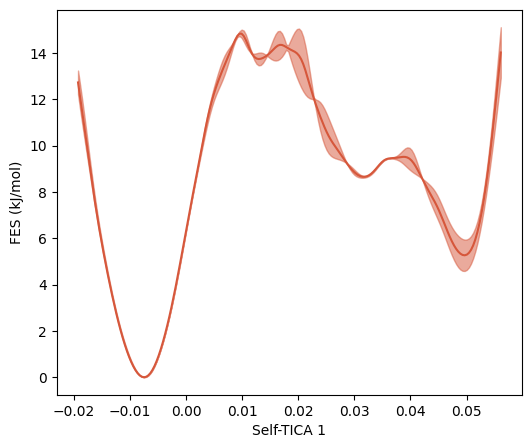

In [10]:
fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)

# compute cvs
with torch.no_grad():
    model.eval()
    s = model(torch.Tensor(X)).numpy()

fes,grid,bounds,error = compute_fes(s,
                                    temp=300,
                                    blocks=2,
                                    bandwidth=0.02, scale_by='range',
                                    plot=True, plot_max_fes=100, ax = ax)

ax.set_xlabel('Self-TICA 1')
ax.set_ylabel('FES (kJ/mol)')

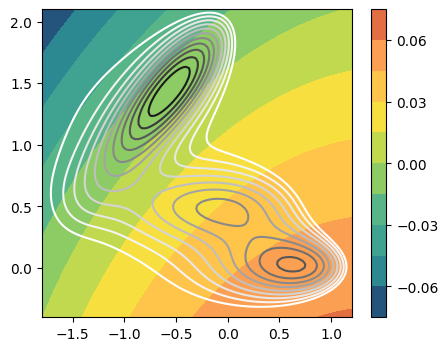

In [11]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]

    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, ax=ax)
    #ax.scatter(X[:,0],X[:,1],s=1, alpha=0.2,c='w')